In [1]:
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import os
import mne
import scipy
import seaborn as sns
from tinnsleep.config import Config  # please add your data path in the module
from tinnsleep.data import CreateRaw, RawToEpochs_sliding
print("Config loaded")

Config loaded


## Ouvre le fichier sur lequel on veut travailler

In [2]:
filename = Config.bruxisme_files[0]  # load file from config

RAW  = mne.io.read_raw_edf(filename, preload=True)
RAW  = RAW.filter(20., 99., n_jobs=1, fir_design='firwin', filter_length='auto', phase='zero-double')
chan = RAW.info["ch_names"]

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/1DA15_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5885999  =      0.000 ... 29429.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 99 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 99.00 Hz
- Upper transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 99.50 Hz)
- Filter length: 661 samples (3.305 sec)



<ipython-input-2-172dcd4313c3>:3: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(filename, preload=True)


## Convertit en Epochs et prend juste les channels d'intérêt de la machoire:

In [3]:
mach1 = chan.index("1")
mach2 = chan.index("2")
Epo = RawToEpochs_sliding(RAW, duration=0.25, interval=0.25, picks=[mach1])
print(Epo)

<Epochs  |   117720 events (good & bad), 0 - 0.25 sec, baseline off, ~7 kB, data not loaded,
 '1': 117720>


## Calcule les puissances de chaque epoch et les stacke dans la liste pwrs

In [1]:
# compute the sum of power over electrodes
pwrs=[]
compt=0
epochs = Epo.get_data()
pwrs = np.sum(epochs ** 2, axis=1)  # extract sum of powers
# test commit

NameError: name 'Epo' is not defined

## Créé l_detect qui marque les epoch ou la puissance est au dessus de 10 fois la valeur moyenne

In [5]:
meany =np.mean(pwrs)
l_detect=[]
compti=0
for elm in pwrs:
    if elm> 10* meany:
        l_detect.append(1)
        compti+=1
    else: 
        l_detect.append(0)
print(compti)

1623


## Affichage de l_detect

In [6]:
%matplotlib qt

In [7]:
plt.figure()
plt.plot(l_detect)

## Fonction qui permet de creer des annotations sur le plot du raw à partir de l_detect

In [8]:
def Annotate(RAW, li, m=0.25, n=0.25):
    #annotations = mne.Annotations([0], [0], "Start")
    if len(RAW.annotations)>0:
        for i in range(len(RAW.annotations)):
            RAW.annotations.delete(0)
    for i in range(len(li)):
        if li[i]==1:
            RAW.annotations.append([n * i], [m], str("bad EPOCH"))
        #else:
        #    '''Detection mauvais channels dans l'epoch et interpole '''
        #    DetectBad(epoch)
            
    
    return

## Permet de faire l'afficchage du signal avec les annotations correspondant aux detections

['1', '1 Imp?dance', '1-2', '1-F', '2', '2 Imp?dance', '2-F', 'Abdomen', 'Abdomen CaL', 'Activity', 'X Axis', 'Y Axis', 'Z Axis', 'C3', 'C3 Imp?dance', 'C3-M2', 'C4', 'C4 Imp?dance', 'C4-M1', 'E1', 'E1 Imp?dance', 'E1-M2', 'E2', 'E2 Imp?dance', 'E2-M1', 'ECG', 'ECG Imp?dance', 'F', 'F Imp?dance', 'F3', 'F3 Imp?dance', 'F3-M2', 'F4', 'F4 Imp?dance', 'F4-M1', 'Airflow', 'RIP Flow Cal', 'RIP Flow', 'Resp Rate', 'Heart Rate', 'Inductance Abdo', 'Inductance Thor', 'Light', 'Right Leg', 'Jambe droite Im', 'Left Leg', 'Jambe gauche Im', 'K', 'Flow Limitation', 'M1', 'M1 Imp?dance', 'M1M2', 'M2', 'M2 Imp?dance', 'Elevation', 'O1', 'O1 Imp?dance', 'O1-M2', 'O2', 'O2 Imp?dance', 'O2-M1', 'Pulse Waveform', 'RIP-Phase', 'PosAngle', 'Pulse', 'Nasal Pressure', 'PTT', 'PWA', 'Snoring', 'RIP Sum Cal', 'RIP Sum', 'Saturation', 'SpO2 B-B', 'Tension (alimen', 'Tension (Blueto', 'Tension (pile)', 'Thermistance', 'Thorax', 'Volume audio', 'Audio Volume dB']


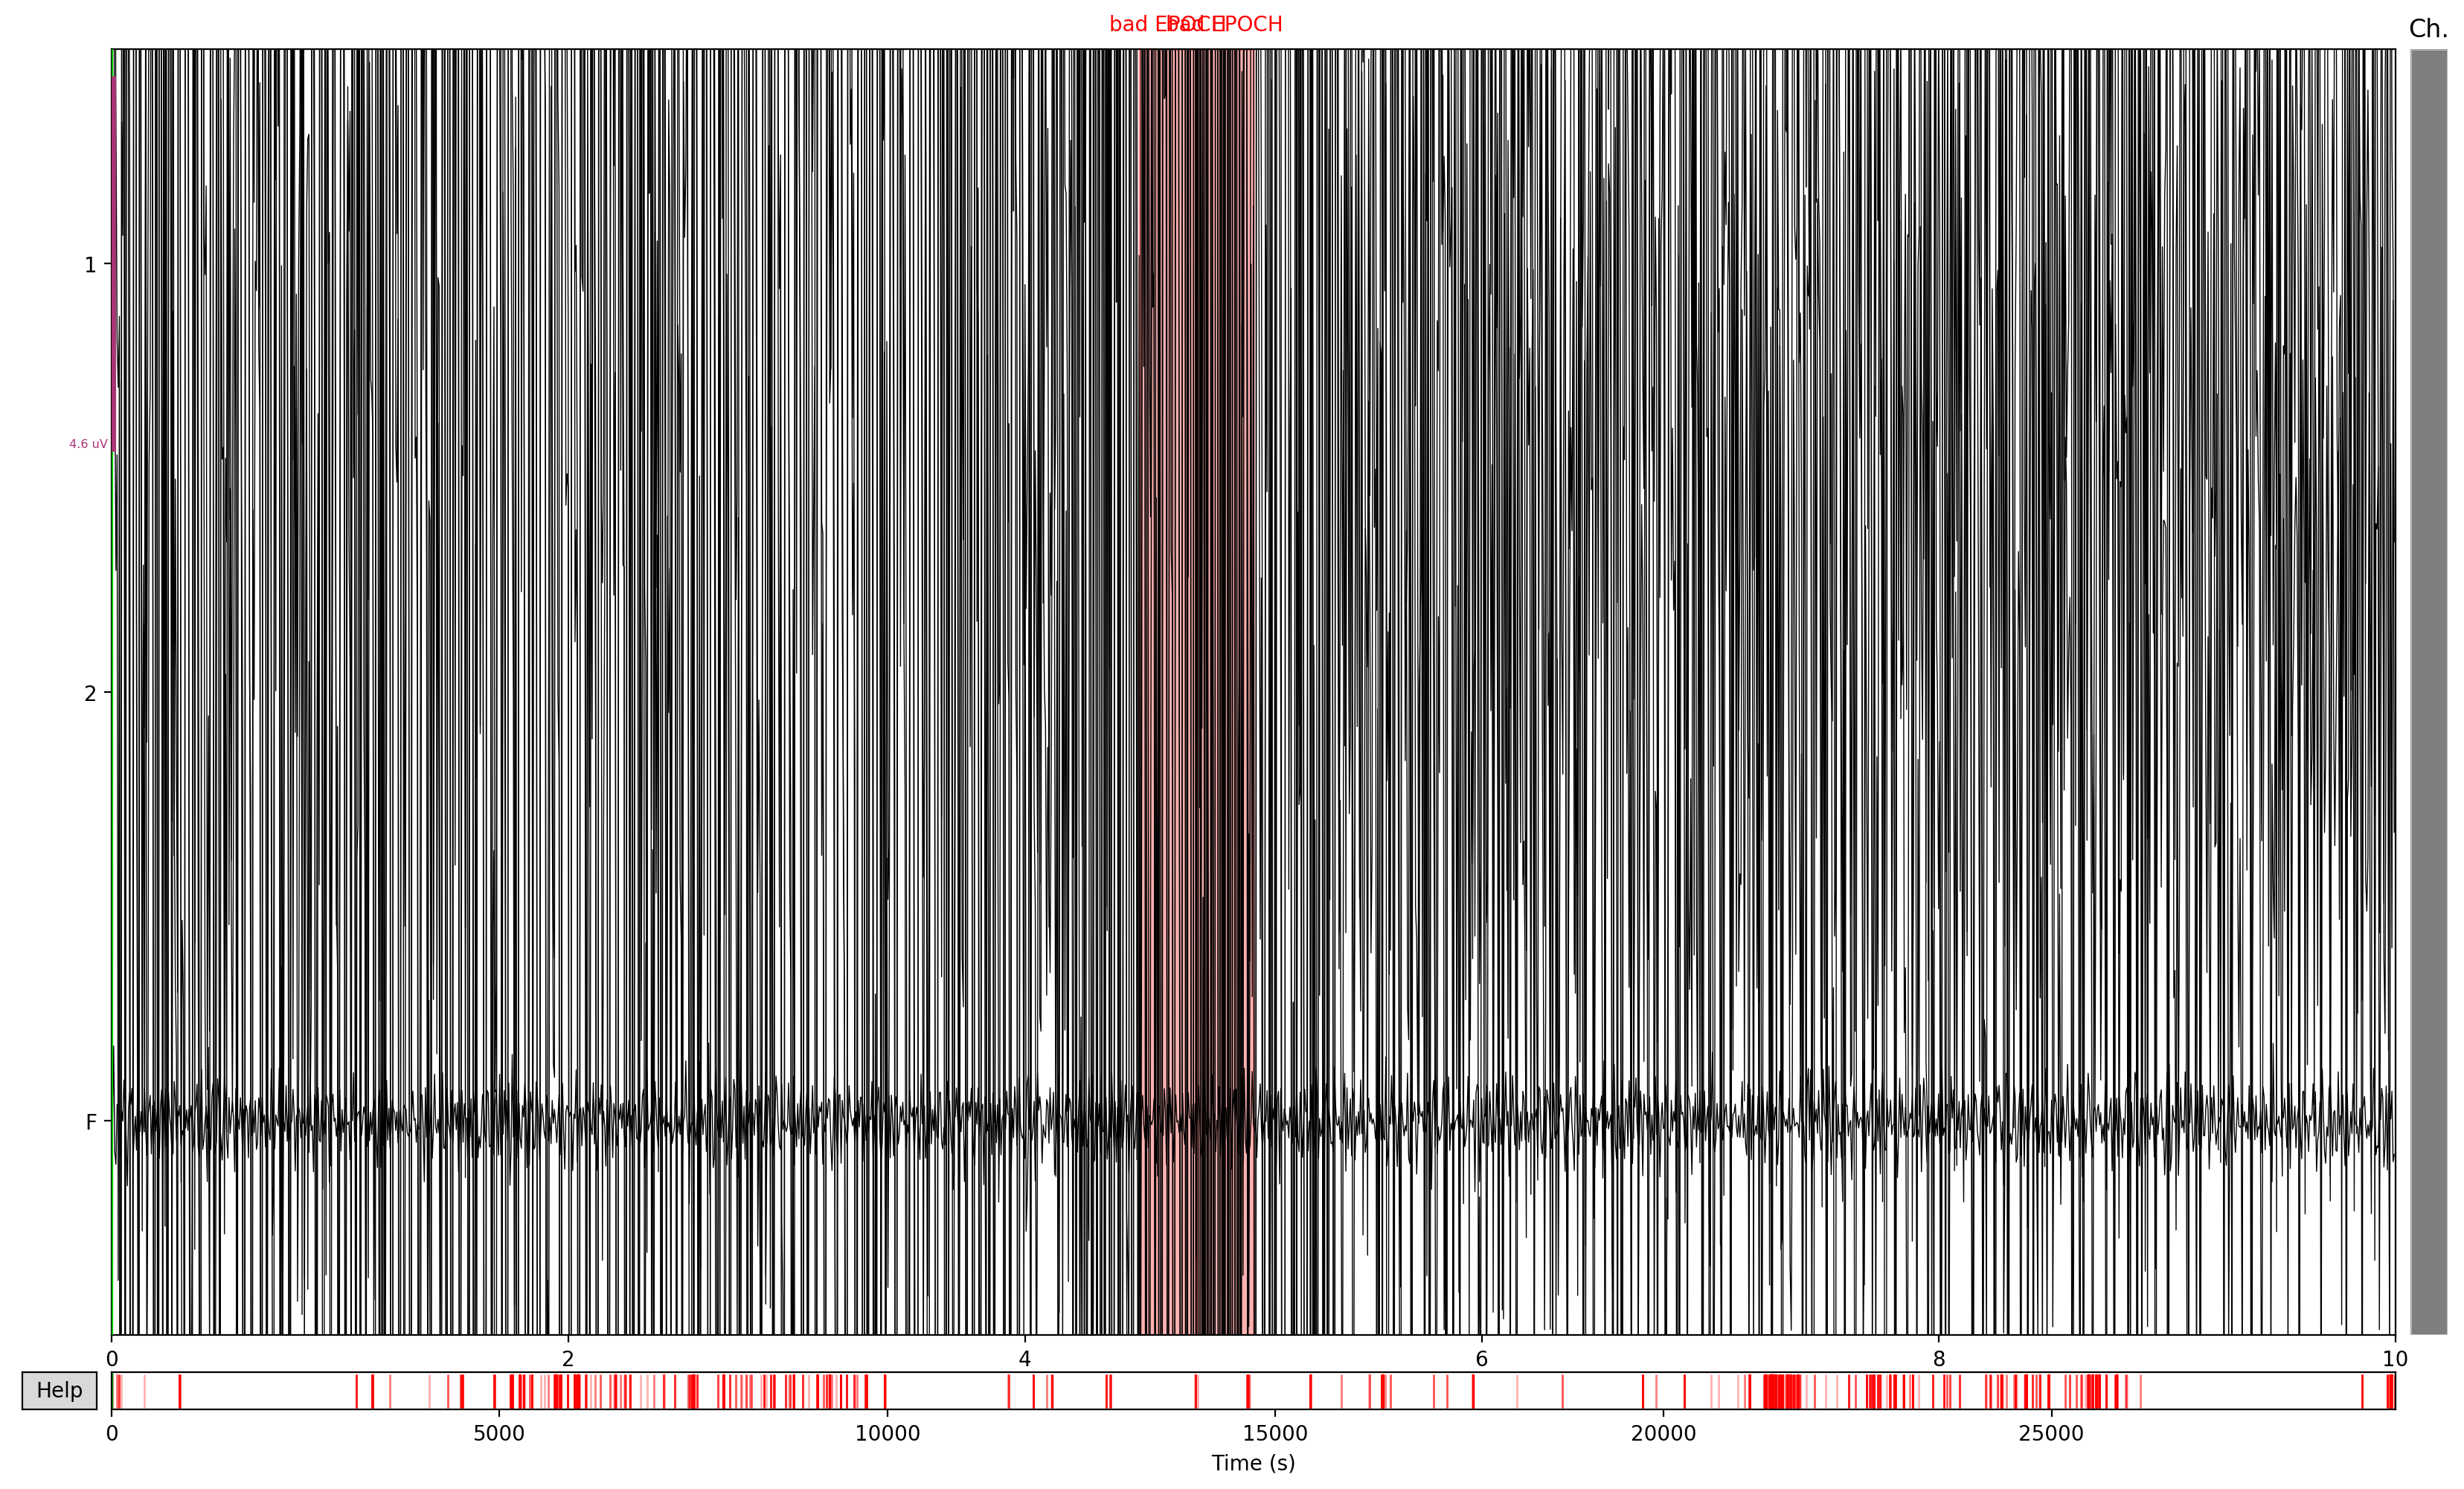

In [9]:
import copy
li=[1,5,28] #impedance channels machoire
chan=RAW.info["ch_names"]


def all_chan_but(lis, chan):
    ret=[]
    for val in chan:
        if not lis.__contains__(val):
            ret.append(val)
    return ret


get_c3=all_chan_but(["1","2","F"], chan)
#get_c3=all_chan_but(["1-2","1-F","2-F"], chan)
li= RAW.info["ch_names"]
print(li)
RAW.drop_channels(get_c3)
#RAW.drop_channels(["Activity","X Axis","Y Axis","Z Axis", "Heart Rate","PosAngle", "Audio Volume dB", "1","1-2",
#                  "1-F","2","2-F","M2 Impedance"])

#RAW = RAW.filter(20., 99., n_jobs=1, fir_design='firwin', filter_length='auto', phase='zero-double')

#On ne prend en compte que les 20 000 premieres annotations
anno = Annotate(RAW,l_detect)
#RAW.annotations = anno
RAW.plot(scalings = 'auto', n_channels = 4)

In [10]:
print(RAW.annotations)

<Annotations  |  1623 segments : bad EPOCH (1623), orig_time : 2019-11-27 23:03:33>


In [11]:
import pandas as pd
li=RAW["1"][:1000][0][0][1000000:1500000]
df = pd.DataFrame(li,columns=['signal'])


In [12]:
print(len(df)/(200*60))

41.666666666666664


In [13]:
%matplotlib inline

## Affiche les distributions des epochs créés

[-2.00608217e-07  2.00213691e-05  1.06899945e-05  4.65605548e-06
  1.60173096e-06 -1.13411799e-06 -1.73620569e-06 -8.47286955e-07
 -3.01629494e-05  5.58652576e-06  3.75275509e-06  1.09694757e-05
 -1.44962914e-05  1.35149940e-05  1.64941971e-05  4.14249758e-06
  1.78125586e-06 -2.43640206e-05 -2.23338213e-05 -6.47753739e-06
  2.49730145e-05  1.72723958e-05 -4.38680676e-06 -9.03782708e-06
 -1.45529604e-05  2.63344024e-05 -3.10977345e-07 -8.61120387e-06
 -4.69193448e-06 -5.99840609e-06  3.41941148e-06 -6.18304609e-06
 -1.54529570e-08  4.04739442e-06  5.19351202e-06  1.44574300e-05
  2.69855826e-06 -1.43226199e-05 -2.32613199e-05  2.10252994e-05
  1.64684050e-06 -2.74610378e-05  1.82916934e-05  1.09970199e-05
  8.95224202e-07 -8.86698381e-06  9.96484303e-06 -6.10841812e-06
  7.44437757e-06 -3.02686238e-05  3.95818930e-06]


RuntimeError: Since bad epochs have not been dropped, the length of the Epochs is not known. Load the Epochs with preload=True, or call Epochs.drop_bad(). To find the number of events in the Epochs, use len(Epochs.events).

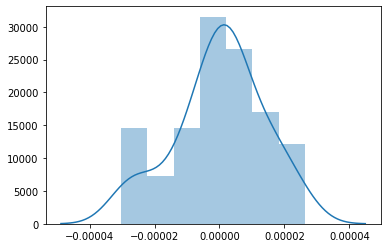

<Figure size 432x288 with 0 Axes>

In [14]:
print(Epo[0].get_data()[0][0])
plt.figure()
sns.distplot(Epo[0].get_data()[0][0])

plt.figure()
print(int(len(Epo)/100))
for i in range(int(len(Epo)/100)):
    sns.distplot(Epo[100*i].get_data()[0][0])

## Créé les transformées de Fourier (Welch) des epochs et récupère les coefficients entre 20 et 100 Hz

In [ ]:
#Epo.plot(scalings = 'auto', n_channels = 3)
def Extract_Alpha(E):
        AP = []
        print (len(E))
        flag = 0
        for epoch in E:

            #print len(epoch[0])

            #Il se passe des choses bizarres ici !! 

            FFTBIS = scipy.signal.welch(epoch, fs=200.0, window='hanning')
            if flag == 0 :
                print (len(epoch))
                print (FFTBIS[0][20:100])
                print (len(FFTBIS[0]))
                flag = 1
            ap = 0
            
            ap=FFTBIS[1][0][20:100]    #seulement la channel 1, de 20Hz à 50Hz
            
            AP.append(ap)


        return(AP)

get_al=Extract_Alpha(Epo)
print(get_al[:10])

## Affiche l'ensemble des FFTs précedemment calculées

In [ ]:
plt.figure()
print(int(len(get_al)/100))
for i in range(int(len(get_al)/100)):
    plt.plot(get_al[100*i])